# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf

warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']
defender_df = defender_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [defender_df.columns[i] for i,x in enumerate(defender_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
defender_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

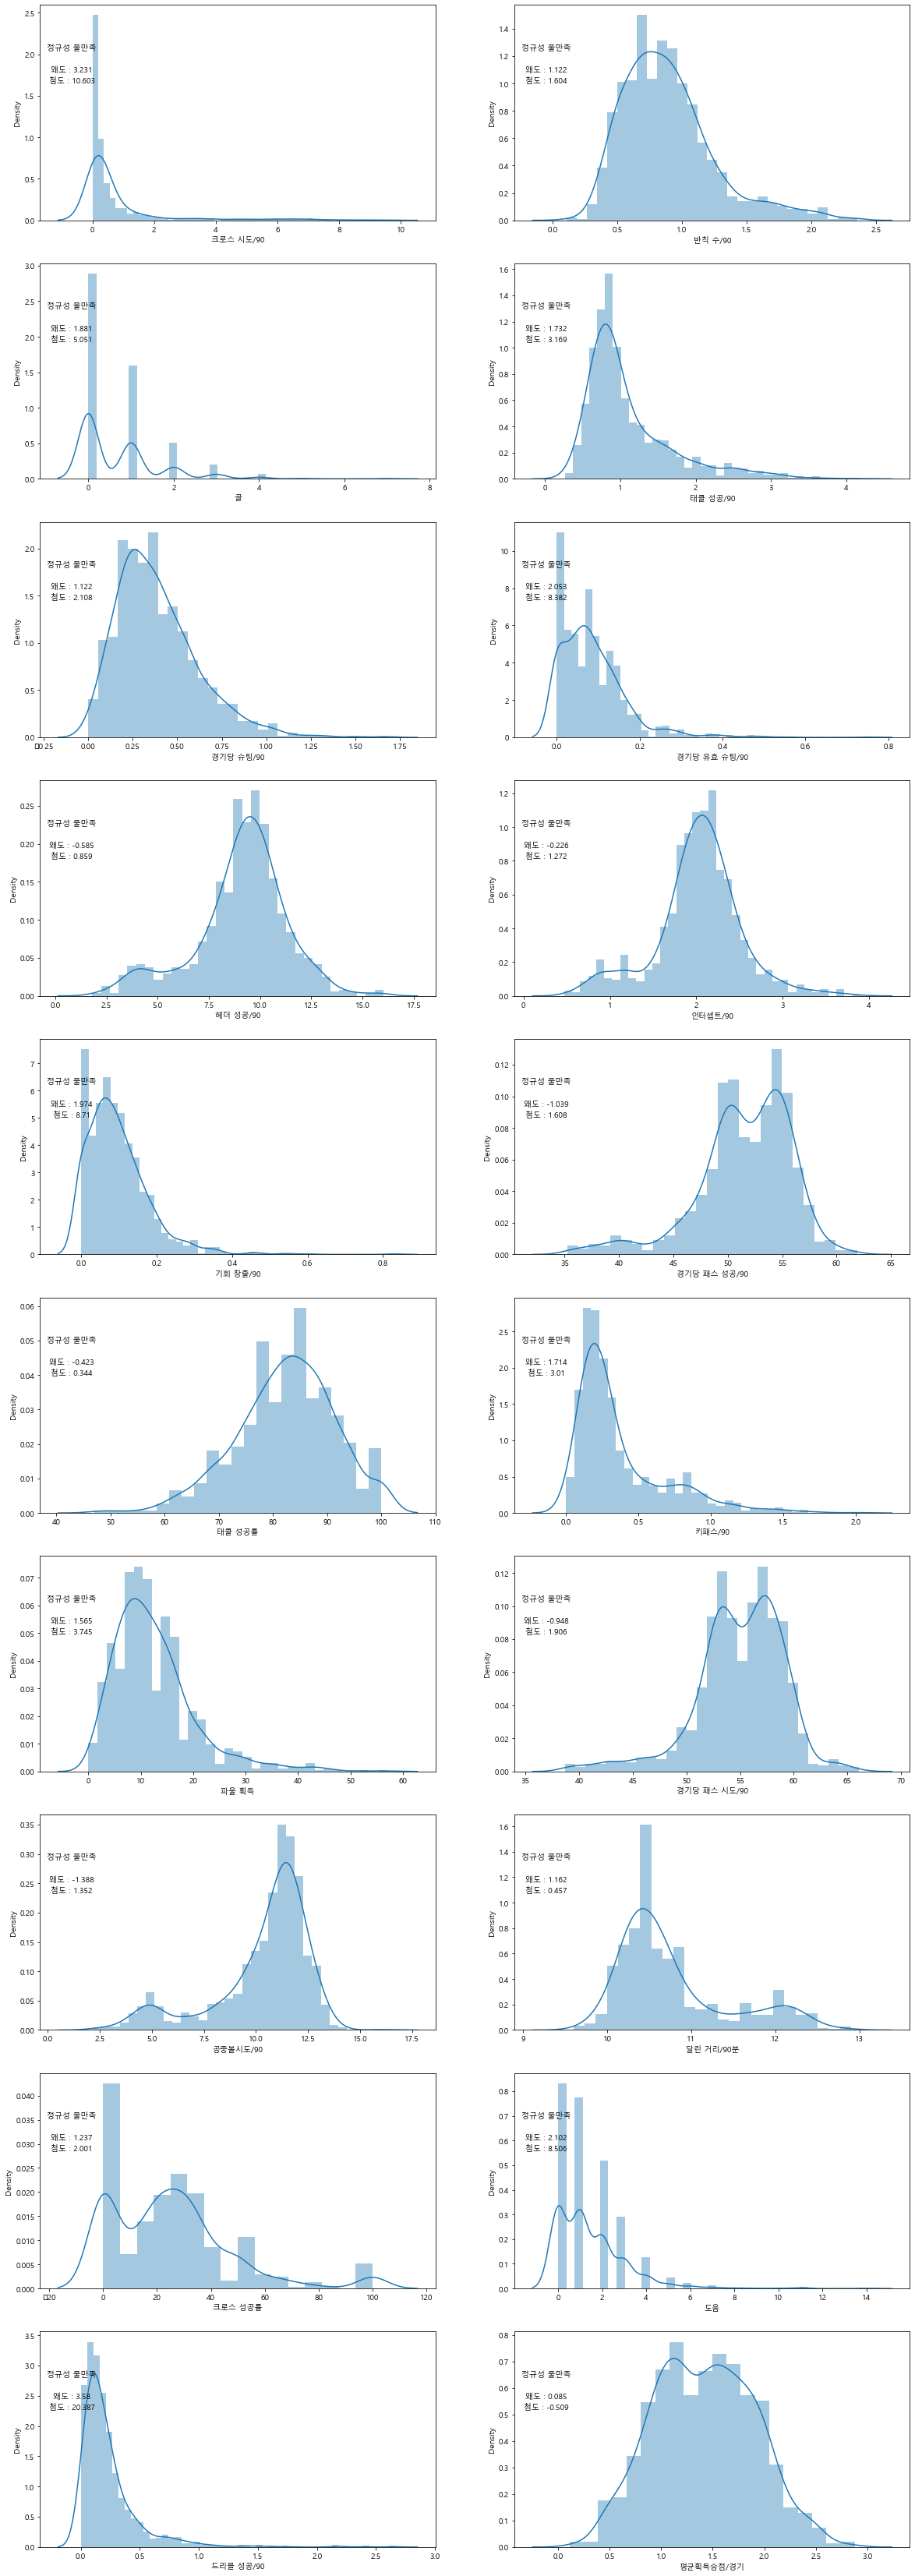

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = defender_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = defender_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

모든 변수가 정규성 불만족 -> 정규화 필요

## 이상치 탐지

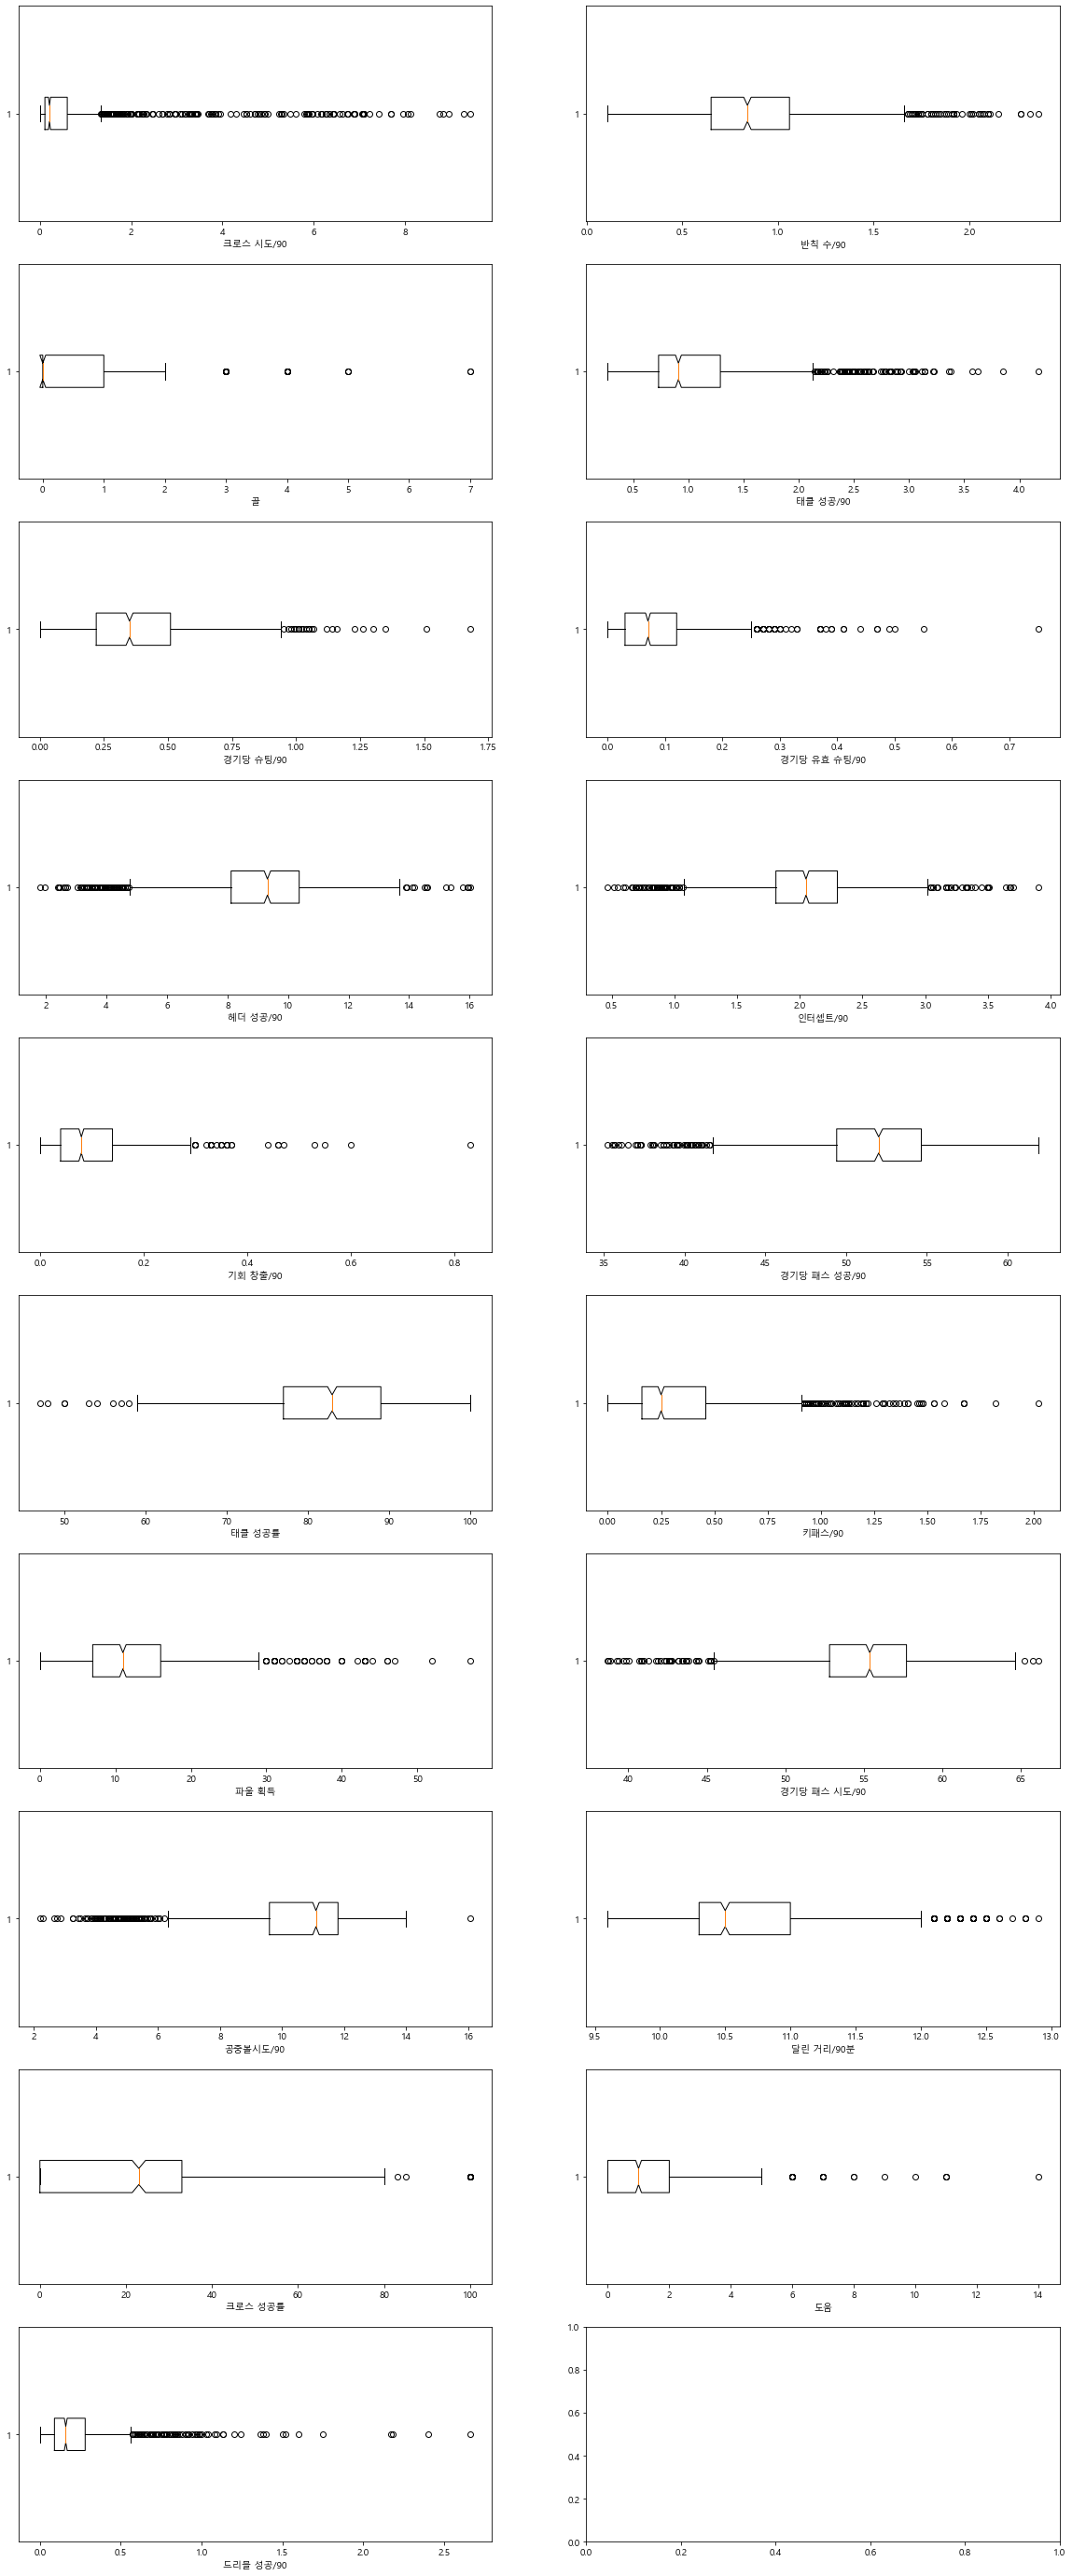

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(defender_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = defender_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(defender_df)}개의 데이터 중 {len(total)} 개 입니다.')

크로스 시도/90중 이상치는 190개 비율은 약 19.192% 입니다

반칙 수/90중 이상치는 68개 비율은 약 6.869% 입니다

골중 이상치는 62개 비율은 약 6.263% 입니다

태클 성공/90중 이상치는 121개 비율은 약 12.222% 입니다

경기당 슈팅/90중 이상치는 44개 비율은 약 4.444% 입니다

경기당 유효 슈팅/90중 이상치는 56개 비율은 약 5.657% 입니다

헤더 성공/90중 이상치는 105개 비율은 약 10.606% 입니다

인터셉트/90중 이상치는 128개 비율은 약 12.929% 입니다

기회 창출/90중 이상치는 58개 비율은 약 5.859% 입니다

경기당 패스 성공/90중 이상치는 55개 비율은 약 5.556% 입니다

태클 성공률중 이상치는 16개 비율은 약 1.616% 입니다

키패스/90중 이상치는 168개 비율은 약 16.97% 입니다

파울 획득중 이상치는 58개 비율은 약 5.859% 입니다

경기당 패스 시도/90중 이상치는 51개 비율은 약 5.152% 입니다

공중볼시도/90중 이상치는 113개 비율은 약 11.414% 입니다

달린 거리/90분중 이상치는 180개 비율은 약 18.182% 입니다

크로스 성공률중 이상치는 38개 비율은 약 3.838% 입니다

도움중 이상치는 23개 비율은 약 2.323% 입니다

드리블 성공/90중 이상치는 109개 비율은 약 11.01% 입니다

이상치가 있는 row의 갯수는 총 1109개의 데이터 중 455 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

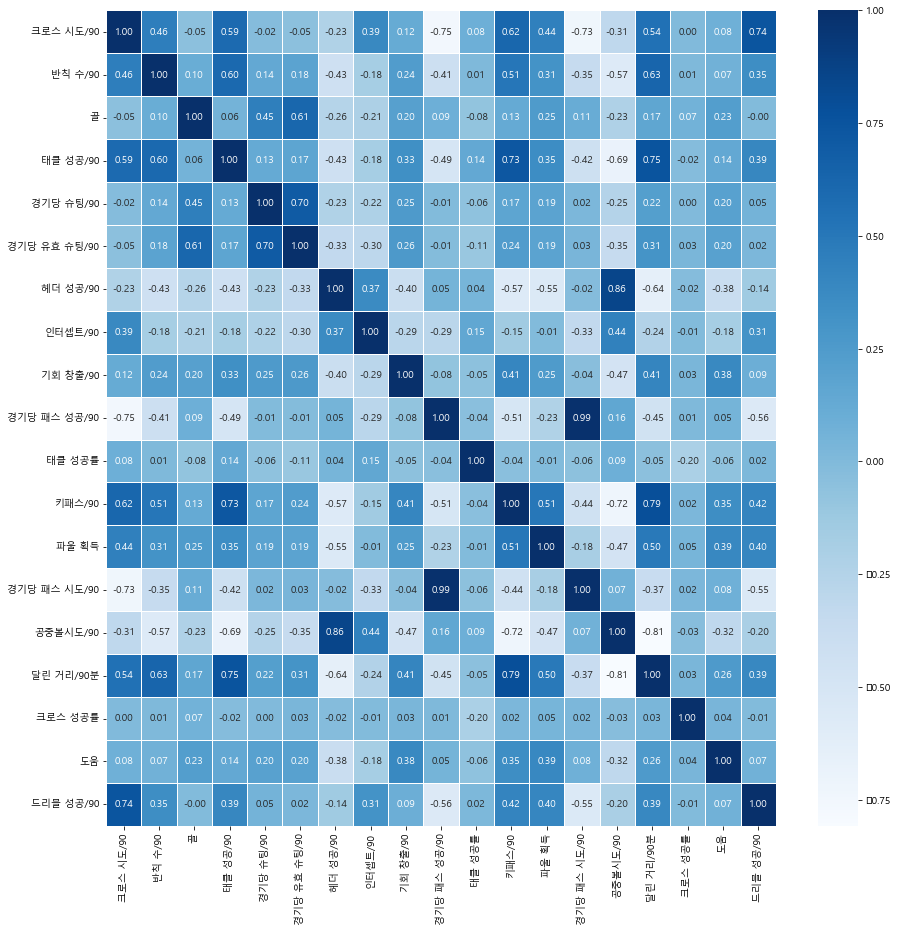

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = defender_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 종속변수 간 상관계수 , 독립변수와 상관계수

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(defender_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,헤더 성공/90,공중볼시도/90,0.809410
1,경기당 패스 성공/90,경기당 패스 시도/90,0.984444


In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(defender_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])

,종속변수,독립변수,상관계수
0,크로스 시도/90,평균획득승점/경기,-0.012587
1,반칙 수/90,평균획득승점/경기,-0.027635
2,골,평균획득승점/경기,0.170350
3,태클 성공/90,평균획득승점/경기,0.045919
4,경기당 슈팅/90,평균획득승점/경기,0.146920
5,경기당 유효 슈팅/90,평균획득승점/경기,0.114028
6,헤더 성공/90,평균획득승점/경기,-0.050992
7,인터셉트/90,평균획득승점/경기,-0.043183
8,기회 창출/90,평균획득승점/경기,0.102824
9,경기당 패스 성공/90,평균획득승점/경기,0.287751


### 다중공선성

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,2.317019,크로스 성공률
1,2.617942,골
2,2.768307,도움
3,3.400982,기회 창출/90
4,4.284752,드리블 성공/90
5,6.140404,경기당 유효 슈팅/90
6,7.016776,파울 획득
7,7.857907,경기당 슈팅/90
8,7.921314,크로스 시도/90
9,10.163174,키패스/90


# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [12]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [13]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(defender_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 헤더, 공중볼
2. 패스시도, 패스성공
3. 태클성공,태클성공률

### 헤더, 공중볼

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [18]:
defender_df[['헤더 성공/90','공중볼시도/90','평균획득승점/경기']].corr()

,헤더 성공/90,공중볼시도/90,평균획득승점/경기
헤더 성공/90,1.000000,0.855105,-0.033153
공중볼시도/90,0.855105,1.000000,-0.066098
평균획득승점/경기,-0.033153,-0.066098,1.000000


#### 피쳐 엔지니어링

In [33]:
# header accuracy
defender_df['HA'] = (defender_df['헤더 성공/90'] / defender_df['공중볼시도/90'])

independent_value.add('HA')
independent_value = independent_value - set(['헤더 성공/90','공중볼시도/90'])

defender_df[['이름','HA']].sort_values(by='HA',ascending=False).head()

,이름,HA
839,Ali Al Musrati,2.267813
612,Rodri,1.848548
309,Danilo Cataldi,1.805556
99,Daniel Amartey,1.797661
1040,Leander Dendoncker,1.528384


#### 상관계수 확인 (통과)

In [34]:
defender_df[['HA','평균획득승점/경기']].corr()

,HA,평균획득승점/경기
HA,1.000000,0.076855
평균획득승점/경기,0.076855,1.000000


### 패스시도, 패스성공

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균(0.25)보다 높은 피쳐를 만들자)

In [35]:
defender_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.986422,0.251056
경기당 패스 시도/90,0.986422,1.000000,0.255630
평균획득승점/경기,0.251056,0.255630,1.000000


#### 피쳐 엔지니어링

In [46]:
# 0도움인 선수 보정

# Pass Accuracy Weighted Assist And Keypass
defender_df['WPA'] = (defender_df['경기당 패스 성공/90'] + defender_df['경기당 패스 시도/90'])

independent_value.add('WPA')
independent_value = independent_value - set(['경기당 패스 시도/90','경기당 패스 성공/90'])

defender_df[['이름','WPA']].sort_values(by='WPA',ascending=False).head()

,이름,WPA
612,Rodri,127.87
970,João Palhinha,127.63
51,Ellyes Skhiri,126.47
288,William Carvalho,124.76
105,Fernando,124.51


#### 상관계수 확인 (통과)

In [50]:
defender_df[['WPA','평균획득승점/경기']].corr()

,WPA,평균획득승점/경기
WPA,1.000000,0.254151
평균획득승점/경기,0.254151,1.000000


#### 다중 공선성 재확인

In [51]:
check_vif(independent_value)

,VIF 계수,종속변수
0,2.108582,SAWG
1,2.304360,크로스 성공률
2,2.750125,도움
3,3.295673,기회 창출/90
4,4.193944,드리블 성공/90
5,6.744864,파울 획득
6,7.630732,크로스 시도/90
7,8.973908,키패스/90
8,13.535753,반칙 수/90
9,18.727679,태클 성공/90


### 태클 성공률, 태클 성공/90

#### 태클 성공률, 태클 성공/90 제거 -> 90분당 태클 시도 생성

In [52]:
defender_df['태클 시도/90'] = defender_df['태클 성공/90']/defender_df['태클 성공률']

In [53]:
defender_df[['태클 시도/90','태클 성공/90','태클 성공률','평균획득승점/경기']].corr()

,태클 시도/90,태클 성공/90,태클 성공률,평균획득승점/경기
태클 시도/90,1.000000,0.976461,-0.048661,0.042643
태클 성공/90,0.976461,1.000000,0.143174,0.027461
태클 성공률,-0.048661,0.143174,1.000000,-0.052896
평균획득승점/경기,0.042643,0.027461,-0.052896,1.000000


In [56]:
defender_df['태클'] = (defender_df['태클 성공/90'])+(defender_df['태클 시도/90'])-defender_df['태클 성공률']
defender_df[['태클','평균획득승점/경기']].corr()

,태클,평균획득승점/경기
태클,1.000000,0.055093
평균획득승점/경기,0.055093,1.000000


In [58]:
independent_value.add('태클 시도/90')
independent_value.add('태클')
independent_value = independent_value-set(['태클 성공률','태클 성공/90' ,'태클 시도/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,2.106165,SAWG
1,2.303423,크로스 성공률
2,2.747572,도움
3,3.292092,기회 창출/90
4,4.167934,드리블 성공/90
5,6.684628,파울 획득
6,7.050246,크로스 시도/90
7,8.211661,키패스/90
8,13.068670,반칙 수/90
9,30.990393,인터셉트/90


종속변수에 영향이 적은 인터셉트 제거, 크로스 시도 제거를 통해 해결

In [70]:
independent_value = independent_value - set(['크로스 시도/90','인터셉트/90','WPA','달린 거리/90분','반칙 수/90'])

In [71]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


In [72]:
check_vif(independent_value)

,VIF 계수,종속변수
0,1.966966,SAWG
1,2.193164,크로스 성공률
2,2.426377,드리블 성공/90
3,2.540994,도움
4,3.149977,기회 창출/90
5,4.332146,키패스/90
6,5.866746,파울 획득
7,30.700280,HA
8,31.198540,태클


### 파울 획득, 반칙 수

상관계수가 0.7 보다 높고 VIF가 10보다 높기 떄문에 기준에 벗어나지만 모델생성후 변수에 대해 다시 고려하기로 함

### 달린 거리/90

VIF가 너무 높기 때문에 삭제결정

In [73]:
independent_value= independent_value - set(['달린 거리/90분'])

### 최종 종속변수

In [74]:
independent_value

{'HA',
 'SAWG',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '크로스 성공률',
 '키패스/90',
 '태클',
 '파울 획득'}

In [75]:
defender_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', 'SAWG', 'HA', 'WPA', '태클 시도/90', '태클'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

### 독립변수,종속변수 정규화

In [76]:
# 데이터의 2/3 수준의 quantile 적용

defender_qt = QuantileTransformer(n_quantiles=500).fit(defender_df.loc[:,independent_value])
defender_df.loc[:,independent_value] = defender_qt.transform(defender_df.loc[:,independent_value])

In [77]:
independent_value

{'HA',
 'SAWG',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '크로스 성공률',
 '키패스/90',
 '태클',
 '파울 획득'}

In [78]:
fx_train,fx_test,fy_train,fy_test = train_test_split(defender_df.loc[:,independent_value],defender_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [79]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.02))(inputs_layer)
hidden2 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.02))(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
13/13 [==============================] - 1s 14ms/step - loss: 2.2651 - val_loss: 1.9268
Epoch 2/500
13/13 [==============================] - 0s 5ms/step - loss: 1.5830 - val_loss: 1.2789
Epoch 3/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0747 - val_loss: 0.9009
Epoch 4/500
13/13 [==============================] - 0s 4ms/step - loss: 0.8898 - val_loss: 0.8411
Epoch 5/500
13/13 [==============================] - 0s 5ms/step - loss: 0.8422 - val_loss: 0.7944
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 0.7962 - val_loss: 0.7565
Epoch 7/500
13/13 [==============================] - 0s 5ms/step - loss: 0.7574 - val_loss: 0.7177
Epoch 8/500
13/13 [==============================] - 0s 5ms/step - loss: 0.7200 - val_loss: 0.6808
Epoch 9/500
13/13 [==============================] - 0s 5ms/step - loss: 0.6825 - val_loss: 0.6466
Epoch 10/500
13/13 [==============================] - 0s 4ms/step - loss: 0.6495 - val_loss: 0.6192
Epoch 11

13/13 [==============================] - 0s 5ms/step - loss: 0.2400 - val_loss: 0.2361
Epoch 84/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2401 - val_loss: 0.2342
Epoch 85/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2388 - val_loss: 0.2350
Epoch 86/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2381 - val_loss: 0.2338
Epoch 87/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2377 - val_loss: 0.2335
Epoch 88/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2378 - val_loss: 0.2335
Epoch 89/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2372 - val_loss: 0.2319
Epoch 90/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2357 - val_loss: 0.2329
Epoch 91/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2356 - val_loss: 0.2310
Epoch 92/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2353 - val_loss: 0.2309
Epoch 93/500


13/13 [==============================] - 0s 7ms/step - loss: 0.2220 - val_loss: 0.2186
Epoch 165/500
13/13 [==============================] - 0s 7ms/step - loss: 0.2219 - val_loss: 0.2186
Epoch 166/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2220 - val_loss: 0.2181
Epoch 167/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2226 - val_loss: 0.2193
Epoch 168/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2218 - val_loss: 0.2178
Epoch 169/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2218 - val_loss: 0.2201
Epoch 170/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2218 - val_loss: 0.2178
Epoch 171/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2219 - val_loss: 0.2189
Epoch 172/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2225 - val_loss: 0.2188
Epoch 173/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2228 - val_loss: 0.2185
Epoc

13/13 [==============================] - 0s 6ms/step - loss: 0.2187 - val_loss: 0.2180
Epoch 246/500
13/13 [==============================] - 0s 7ms/step - loss: 0.2194 - val_loss: 0.2161
Epoch 247/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2197 - val_loss: 0.2157
Epoch 248/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2199 - val_loss: 0.2196
Epoch 249/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2191 - val_loss: 0.2154
Epoch 250/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2203 - val_loss: 0.2168
Epoch 251/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2195 - val_loss: 0.2177
Epoch 252/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2191 - val_loss: 0.2158
Epoch 253/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2185 - val_loss: 0.2165
Epoch 254/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2208 - val_loss: 0.2167
Epoc

13/13 [==============================] - 0s 5ms/step - loss: 0.2179 - val_loss: 0.2152
Epoch 327/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2177 - val_loss: 0.2149
Epoch 328/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2179 - val_loss: 0.2182
Epoch 329/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2177 - val_loss: 0.2161
Epoch 330/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2192 - val_loss: 0.2160
Epoch 331/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2176 - val_loss: 0.2164
Epoch 332/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2170 - val_loss: 0.2158
Epoch 333/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2184 - val_loss: 0.2150
Epoch 334/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2179 - val_loss: 0.2172
Epoch 335/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2171 - val_loss: 0.2159
Epoc

13/13 [==============================] - 0s 4ms/step - loss: 0.2155 - val_loss: 0.2150
Epoch 408/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2152 - val_loss: 0.2134
Epoch 409/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2162 - val_loss: 0.2156
Epoch 410/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2159 - val_loss: 0.2159
Epoch 411/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2155 - val_loss: 0.2147
Epoch 412/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2168 - val_loss: 0.2185
Epoch 413/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2154 - val_loss: 0.2140
Epoch 414/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2143 - val_loss: 0.2160
Epoch 415/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2154 - val_loss: 0.2139
Epoch 416/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2151 - val_loss: 0.2148
Epoc

13/13 [==============================] - 0s 5ms/step - loss: 0.2149 - val_loss: 0.2126
Epoch 489/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2172 - val_loss: 0.2180
Epoch 490/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2129 - val_loss: 0.2121
Epoch 491/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2142 - val_loss: 0.2138
Epoch 492/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2141 - val_loss: 0.2122
Epoch 493/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2138 - val_loss: 0.2128
Epoch 494/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2142 - val_loss: 0.2142
Epoch 495/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2142 - val_loss: 0.2144
Epoch 496/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2145 - val_loss: 0.2137
Epoch 497/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2161 - val_loss: 0.2152
Epoc

0.3618130876244725

## 변수선택법

In [42]:
from statsmodels.regression.linear_model import OLS

ols_model = OLS(fy_train,fx_train)
regr = ols_model.fit()
best_aic = regr.aic
best_aic

1585.0680331274282

In [43]:
best_values = []

for i in range(len(independent_value)+1,1,-1):
    for var in list(combinations(independent_value,i)):
        ols_model = OLS(fy_train,fx_train.loc[:,var])
        regr = ols_model.fit()
        if best_aic<regr.aic:
            pass
        else:
            best_aic = regr.aic
            best_values = var
best_values

('크로스 성공률', 'SAWG', '반칙 수/90', 'PAWAAK', '기회 창출/90', '드리블 성공/90')

In [44]:
best_aic

1584.0460144196832

In [45]:
independent_value = best_values

In [46]:
fx_train,fx_test,fy_train,fy_test = train_test_split(defender_df.loc[:,independent_value],defender_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [47]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.02))(inputs_layer)
hidden2 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.02))(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
13/13 [==============================] - 0s 14ms/step - loss: 2.7415 - val_loss: 2.5910
Epoch 2/500
13/13 [==============================] - 0s 6ms/step - loss: 2.3850 - val_loss: 2.2599
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 2.0458 - val_loss: 1.8855
Epoch 4/500
13/13 [==============================] - 0s 6ms/step - loss: 1.6601 - val_loss: 1.4564
Epoch 5/500
13/13 [==============================] - 0s 6ms/step - loss: 1.2447 - val_loss: 1.0518
Epoch 6/500
13/13 [==============================] - 0s 6ms/step - loss: 0.9137 - val_loss: 0.7858
Epoch 7/500
13/13 [==============================] - 0s 7ms/step - loss: 0.7577 - val_loss: 0.7221
Epoch 8/500
13/13 [==============================] - 0s 6ms/step - loss: 0.7251 - val_loss: 0.6891
Epoch 9/500
13/13 [==============================] - 0s 6ms/step - loss: 0.6886 - val_loss: 0.6577
Epoch 10/500
13/13 [==============================] - ETA: 0s - loss: 0.726 - 0s 6ms/step - loss: 0.6573 - v

13/13 [==============================] - 0s 6ms/step - loss: 0.2331 - val_loss: 0.2226
Epoch 164/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2333 - val_loss: 0.2237
Epoch 165/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2331 - val_loss: 0.2238
Epoch 166/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2331 - val_loss: 0.2226
Epoch 167/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2327 - val_loss: 0.2233
Epoch 168/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2328 - val_loss: 0.2235
Epoch 169/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2327 - val_loss: 0.2229
Epoch 170/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2327 - val_loss: 0.2231
Epoch 171/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2328 - val_loss: 0.2228
Epoch 172/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2328 - val_loss: 0.2236
Epoc

13/13 [==============================] - 0s 6ms/step - loss: 0.2311 - val_loss: 0.2210
Epoch 326/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2310 - val_loss: 0.2218
Epoch 327/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2314 - val_loss: 0.2205
Epoch 328/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2311 - val_loss: 0.2226
Epoch 329/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2308 - val_loss: 0.2205
Epoch 330/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2315 - val_loss: 0.2207
Epoch 331/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2325 - val_loss: 0.2204
Epoch 332/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2320 - val_loss: 0.2221
Epoch 333/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2324 - val_loss: 0.2205
Epoch 334/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2313 - val_loss: 0.2208
Epoc

13/13 [==============================] - 0s 6ms/step - loss: 0.2292 - val_loss: 0.2209
Epoch 488/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2299 - val_loss: 0.2198
Epoch 489/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2310 - val_loss: 0.2193
Epoch 490/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2317 - val_loss: 0.2201
Epoch 491/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2296 - val_loss: 0.2192
Epoch 492/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2301 - val_loss: 0.2208
Epoch 493/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2300 - val_loss: 0.2191
Epoch 494/500
13/13 [==============================] - 0s 6ms/step - loss: 0.2294 - val_loss: 0.2203
Epoch 495/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2301 - val_loss: 0.2191
Epoch 496/500
13/13 [==============================] - 0s 5ms/step - loss: 0.2301 - val_loss: 0.2192
Epoc

0.3801857494663547

In [48]:
with open('./models/defender_qt.pickle','wb') as f:
    pickle.dump(defender_qt,f)
model.save('./models/defender_nn.h5')

# 모델검정

In [49]:
defender_df['predict'] = model.predict(defender_df.loc[:,independent_value])

In [50]:
residual = defender_df['평균획득승점/경기'] - defender_df['predict']

## 선형성 검정

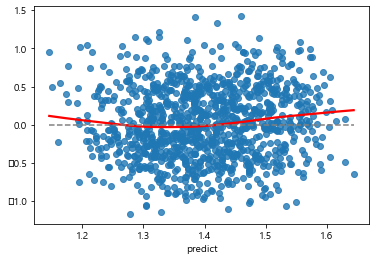

In [51]:
sns.regplot(defender_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([defender_df['predict'].values.min(), defender_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [52]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9948206543922424, pvalue=0.0007411184487864375)

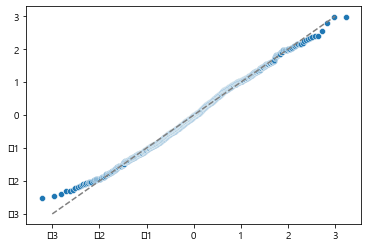

In [53]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

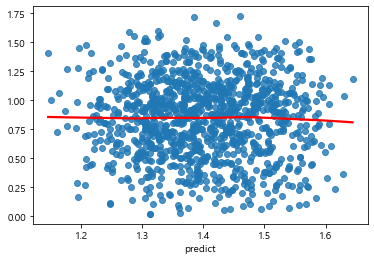

In [54]:
sns.regplot(defender_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [55]:
# 등분산성 불만족
stats.levene(defender_df['평균획득승점/경기'],defender_df['predict'])

LeveneResult(statistic=1528.3360173540486, pvalue=1.03608382002096e-254)